In [1]:
using MyBioTools, MyBioTools.FluTools
using StatsBase, Dates, LaTeXStrings, Statistics
using BioSequences, FastaIO
using CurveFit
using Plots, Measures
pyplot()

Plots.PyPlotBackend()

## Data
All sequences from 2001. Binned by month, without any overlap. 

In [2]:
sp = FluTools.StrainPop("../data/aligned_h3n2_ha.fasta", missingdates = false, seqtype=:nt, segment="ha", strain="h3n2");
println("Found $(length(sp.strains)) strains.")

Translating sequences...
Reading alignment...
Found 57355 strains.


In [3]:
FluTools.bin_by_date!(sp, start=Date(2010), binwidth=Day(15), binspacing=Day(30));

In [4]:
sp.datebin[Date("2004-03-16"), Date("2004-04-15")][1]

KeyError: KeyError: key (2004-03-16, 2004-04-15) not found

In [5]:
fieldnames(FluTools.Strain)

(:aa_seq, :codon_seq, :strain, :segment, :date, :region, :year, :month)

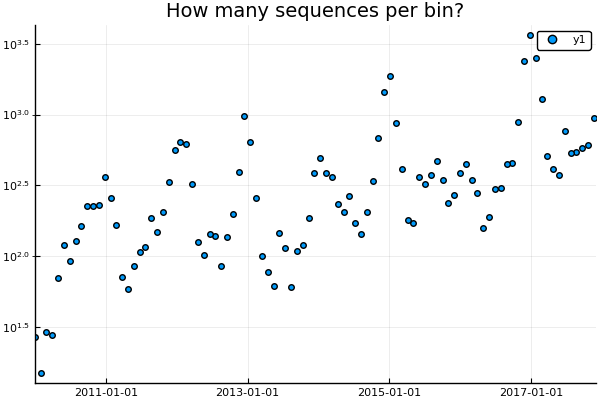

In [6]:
x = [d[1] for d in keys(sp.datebin)]
y = [length(x) for x in values(sp.datebin)]
scatter(x,y, title="How many sequences per bin?", xlim=(Dates.value(Date(2010,1)), Dates.value(Date(2017,12))), yscale=:log10)

It is important to remember that this is the number of sequences per bin, not the amount of statistics backing up a trajectory passing through these bins. A given position might have a majority of `X` symbols for some time bin, giving a statistically unsignificant frequency trajectory.  

### Binning
I will do three bins
- [0.05,0.25] --> minor variants
- [0.25,0.75] 
- [0.75,0.95] --> major variants  

Below 0.05, a variant is considered absent or lost. Above 0.95, it is considered dominant and fixed. 

In [7]:
alphabins = [(0.05,0.25), (0.25,0.75), (0.75, 0.95)]
alphavalues = [mean(x) for x in alphabins];
alphabins_ = [(mean(x), (x[2]-x[1])/2) for x in alphabins]
lost_thr = 0.05
fixed_thr = 0.95;

In [8]:
alphabins_

3-element Array{Tuple{Float64,Float64},1}:
 (0.15, 0.1)                
 (0.5, 0.25)                
 (0.85, 0.09999999999999998)

## Trajectories
All trajectories considered will be conditionned on the fact that the variant was *absent* in the population in the past. This means going back in the past, the variant should be seen under `lost_thr` for at least one timepoint, and this before it is seen above `fixed_thr` if it is the case. 

In [9]:
# History of all positions
L = length(sp.strains[1].aa_seq)
ph = Array{FluTools.PosEvo,1}(undef,L)
for i in 1:L
    print("$i       \r")
    ph[i] = FluTools.positions_history(i, sp)
end

566-element Array{MyBioTools.FluTools.PosEvo,1}:
 MyBioTools.FluTools.PosEvo(1, "M", ["ATG"], Dict((2017-02-23, 2017-03-25)=>Polymorphism(1, Dict('M'=>1076.0), Dict("ATG"=>1076.0)),(2015-12-01, 2015-12-31)=>Polymorphism(1, Dict('M'=>260.0), Dict("ATG"=>260.0)),(2017-01-24, 2017-02-23)=>Polymorphism(1, Dict('M'=>1915.0), Dict("ATG"=>1915.0)),(2015-06-04, 2015-07-04)=>Polymorphism(1, Dict('M'=>355.0), Dict("ATG"=>355.0)),(2012-10-17, 2012-11-16)=>Polymorphism(1, Dict('M'=>173.0), Dict("ATG"=>173.0)),(2016-07-28, 2016-08-27)=>Polymorphism(1, Dict('M'=>294.0), Dict("ATG"=>294.0)),(2016-12-25, 2017-01-24)=>Polymorphism(1, Dict('M'=>2493.0), Dict("ATG"=>2493.0)),(2010-12-27, 2011-01-26)=>Polymorphism(1, Dict('M'=>272.0), Dict("ATG"=>272.0)),(2018-03-20, 2018-04-19)=>Polymorphism(1, Dict('M'=>399.0), Dict("ATG"=>399.0)),(2012-12-16, 2013-01-15)=>Polymorphism(1, Dict('M'=>862.0), Dict("ATG"=>862.0))…))                                                                                             

In [19]:
splice!([1],1)

1

In [85]:
all_traj = FluTools.all_trajectories(ph, keep_unfinished=true)
all_traj = FluTools.previous_state_condition(all_traj, :lost)
all_traj = FluTools.population_size_condition(all_traj, 10)
freqtraj_cf = Dict()
for (α,dα) in alphabins_
    freqtraj_cf[α] = FluTools.frequency_condition(all_traj, α, dα=dα)
    for traj in freqtraj_cf[α]
        FluTools.compute_derivative!(traj)
    end
end

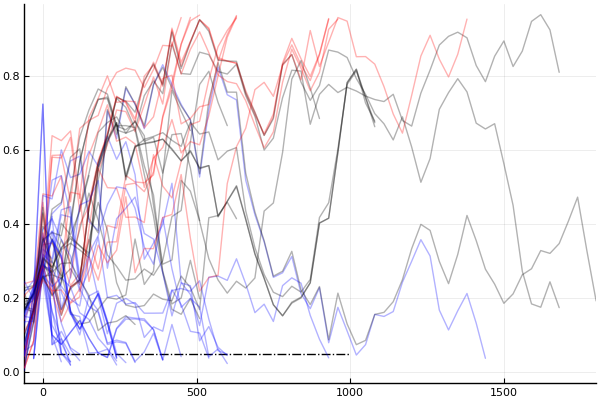

In [107]:
p = plot([-100, 1000], [0.05, 0.05], line=(:black, :dashdot), label="")
for traj in freqtraj_cf[0.5]
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:start]; iend = traj.index[:end]
        if traj.fixation==:lost
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label="", alpha=0.3, color=:blue)
        elseif traj.fixation==:fixed
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label="", alpha=0.3, color=:red)
        else
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label="", alpha=0.3, color=:black)
        end
    end
end
plot!(p, xlim=(-60,1800))

In [87]:
length(all_traj)

314

In [61]:
traj = all_traj[225];

In [98]:
findall(x->x.i==327, freqtraj_cf[0.5])

1-element Array{Int64,1}:
 40

In [103]:
freqtraj_cf[0.5][40].freq

60-element Array{Float64,1}:
 0.03497942386831276
 0.07591623036649214
 0.17142857142857143
 0.44594594594594594
 0.25668449197860965
 0.16929133858267717
 0.22560975609756098
 0.25               
 0.44390243902439025
 0.5647058823529412 
 0.6377025036818851 
 0.7428769979152189 
 0.7330016583747927 
 ⋮                  
 0.7934051144010767 
 0.7577442414614773 
 0.6733333333333333 
 0.6576200417536534 
 0.671875           
 0.563953488372093  
 0.4513888888888889 
 0.27358490566037735
 0.18518518518518517
 0.1761904761904762 
 0.24481327800829875
 0.17506631299734748

In [108]:
println("Fixed fraction: ", length(findall(x->x.fixation==:fixed, freqtraj_cf[0.5]))/length(freqtraj_cf[0.5]) )

Fixed fraction: 0.19607843137254902


In [109]:
spike_idx = findall(x->x.index[:end]-x.index[:start]==2, freqtraj_cf[0.5])

0-element Array{Int64,1}

In [110]:
mean(prop[Day(0)])

UndefVarError: UndefVarError: prop not defined

In [111]:
# Number of trajectories that fixate / dissappear at a given time
loss_count = Dict()
fix_count = Dict()
for traj in freqtraj_cf[0.5]
    if traj.fixation == :lost
        loss_count[traj.t[traj.index[:end]]] = get(loss_count, traj.t[traj.index[:end]], 0) + 1
    elseif traj.fixation == :fixed
        fix_count[traj.t[traj.index[:end]]] = get(fix_count, traj.t[traj.index[:end]], 0) + 1
    end
end
# loss_count = sort(collect(loss_count), by=x->x[1])
# fix_count = sort(collect(fix_count), by=x->x[1]);

# Scaling them to the same time
lv = 0; fv = 0; av = 0;
lc = Dict(); fc = Dict(); ac = Dict()
for t in sort(unique(cat([Day(0)], [x[1] for x in loss_count], [x[1] for x in fix_count], dims=1)))
    lc[t] = get(loss_count, t, 0) + lv
    lv += get(loss_count, t, 0)
    fc[t] = get(fix_count, t, 0) + fv
    fv += get(fix_count, t, 0)
    ac[t] = length(freqtraj_cf[0.5]) - fc[t] - lc[t] 
end
lc = sort(collect(lc), by = x->x[1])
fc = sort(collect(fc), by = x->x[1])
ac = sort(collect(ac), by = x->x[1])
ac;

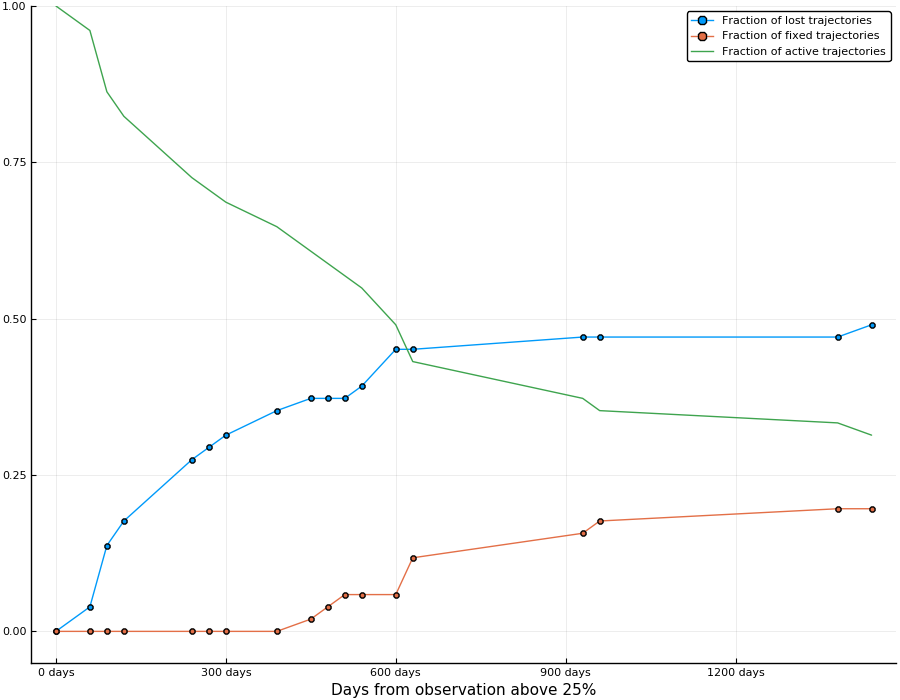

In [112]:
plot([x[1] for x in lc], [x[2] for x in lc]/length(freqtraj_cf[0.5]), label="Fraction of lost trajectories", marker=:o)
plot!([x[1] for x in fc], [x[2] for x in fc]/length(freqtraj_cf[0.5]), label="Fraction of fixed trajectories",marker=:o)
plot!([x[1] for x in ac], [x[2] for x in ac]/length(freqtraj_cf[0.5]), label="Fraction of active trajectories")
plot!(size=(900,700), xlabel="Days from observation above 25%", ylim=(-0.05,1))

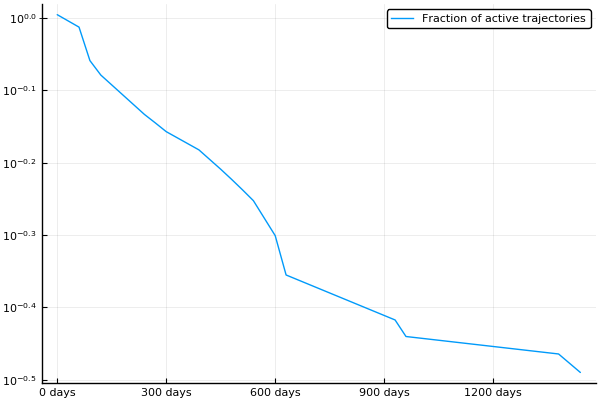

In [113]:
plot([x[1] for x in ac], [x[2] for x in ac]/length(freqtraj_cf[0.5]) .+0.01, yscale=:log10, label="Fraction of active trajectories")


Rougly, 2 years to divide by 10 the number of active trajectories  
--> Time scale 2y / ln(10) = 0.9y

## Average trajectory
Let's plot the average trajectory? 

In [114]:
"""
Helper function for plotting
"""
function fitheatmap(X,Y,nb; th = 0)
    h2 = fit(Histogram, (vec(X), vec(Y)),closed=:left, nbins=nb);
    xx = repeat(collect(h2.edges[1][2:end]), 1, size(collect(h2.edges[2][2:end]),1))';
    yy = repeat(collect(h2.edges[2][2:end]), 1, size(collect(h2.edges[1][2:end]),1));
    zz = h2.weights';
    x = Float64[]; y = Float64[]; z = Int64[];lz=[]
    maxmax = findmax(zz)[1]
    for (nn,v) in enumerate(zz)
        if v!=0 
            push!(x,xx[nn])
            push!(y,yy[nn])
            push!(z,v)
            push!(lz,log(v))
        end
        if (abs(xx[nn]) < th && abs(yy[nn]) < th) 
            push!(x,xx[nn])
            push!(y,yy[nn])
            push!(z,maxmax*10)
        end
    end
return x,y,z
end

fitheatmap

In [115]:
freqs_at_t = Dict{Day, Array{Float64 ,1}}()
for traj in freqtraj_cf[0.5]
    for (t,f) in zip(traj.t, traj.freq)
        if !haskey(freqs_at_t, t)
            freqs_at_t[t] = []
        end
        push!(freqs_at_t[t], f)
    end
end
X = Int64[]; Y = Float64[];
for (t,v) in freqs_at_t
    X = cat(X, repeat([t.value], length(v)), dims=1)
    Y = cat(Y, v, dims=1)
end

In [116]:
x,y,z = fitheatmap(X,Y, (50,10))

([-900.0, -800.0, -700.0, -600.0, -500.0, -500.0, -400.0, -400.0, -300.0, -300.0  …  1800.0, 1800.0, 1900.0, 1900.0, 2000.0, 2100.0, 2100.0, 2200.0, 2200.0, 2200.0], [0.1, 0.1, 0.2, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2  …  0.4, 0.5, 0.2, 0.3, 0.4, 0.4, 0.5, 0.6, 0.8, 0.9], [2, 4, 3, 3, 2, 5, 5, 1, 7, 2  …  1, 2, 3, 1, 3, 1, 2, 1, 2, 1])

In [117]:
p1 = scatter(x,y,zcolor= z, markerstrokewidth=0, seriescolor=grad, label="", title ="") # Remove `legend=:none` for colorbar 
    plot!(p1, framestyle=:box, titlefontsize=lfs, tickfontsize=cbarfontsize,guidefontsize=alfs, gridalpha=ga, size = (900,700),right_margin=5mm,bottom_margin=1mm)


UndefVarError: UndefVarError: grad not defined

In [118]:
scatter(X,Y)
plot!(ts, freq_mean, line=(3,:red))

UndefVarError: UndefVarError: ts not defined

In [119]:
    ## Plot metadata
    lfs = 22 # Legend font size
    alfs = 22 # axis label font size
    tfs = 22 # title font size
    atfs = 22 # axis ticks font size
    cbarfontsize = atfs # Colorbar font size
    ga = 0.3 # grid alpha
    sizes = (1200,800) # standard size for single plots
    rl = 0.065 # position of the "A" or "B" label in % 
    ms = 6 # marker size
    ls = 6 # line size
    grad = :solar;

In [120]:
findmin(z)

(1, 8)

In [121]:
bins = 0.:0.1:1.0
# dist_at_t : distribution at time t accross the 10 frequency bins in `bins`
dist_at_t = Dict{Day, Array{Float64 ,1}}()
for traj in freqtraj_cf[0.5]
    for (t,f) in zip(traj.t, traj.freq)
        w = fit(Histogram, freqs_at_t[t], bins).weights
        dist_at_t[t] = w/sum(w)
    end
end
X = Day[]; Y = Float64[]; Z = Float64[]
for (t,v) in dist_at_t
    for (i,f) in enumerate(collect(bins)[1:end-1])
        if dist_at_t[t][i] > 0
            push!(X, t)
            push!(Y, f + 0.05)
            push!(Z, dist_at_t[t][i])
        end
    end
end
ts = collect(keys(freqs_at_t)); freq_mean = [mean(x) for x in values(freqs_at_t)]
tmp = sortperm(ts); ts = ts[tmp]; freq_mean = freq_mean[tmp];

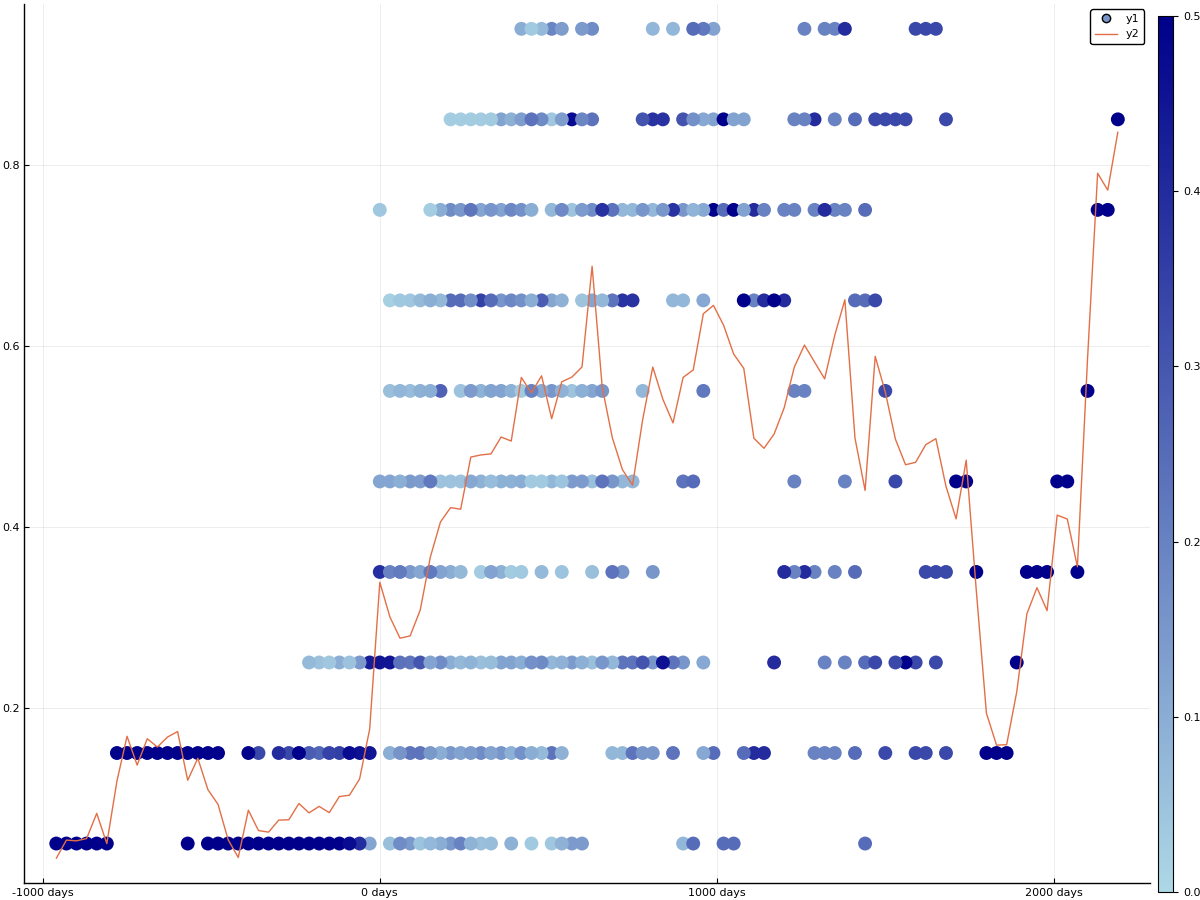

In [122]:
scatter(X,Y,zcolor=Z, seriescolor=:blues, clim=(0,0.5), size = (1200,900), markerstrokewidth=0, markersize = 10)
plot!(ts, freq_mean)

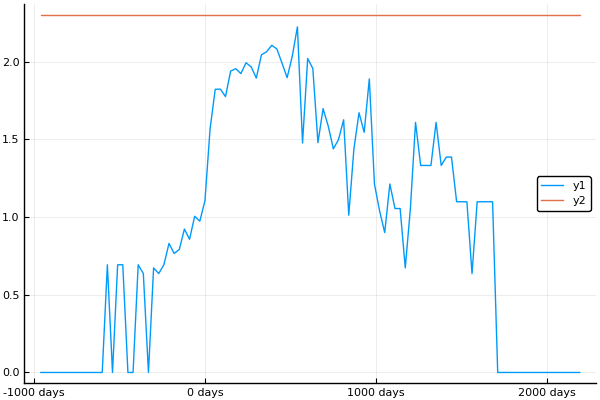

In [123]:
plot(ts, FluTools.treespread_entropy([dist_at_t[x] for x in ts]) )
plot!(ts, repeat([log(10)], length(ts)))
plot!()

In [124]:
dist_at_t[Day(0)]

10-element Array{Float64,1}:
 0.0                
 0.0                
 0.45098039215686275
 0.39215686274509803
 0.11764705882352941
 0.0                
 0.0                
 0.0392156862745098 
 0.0                
 0.0                

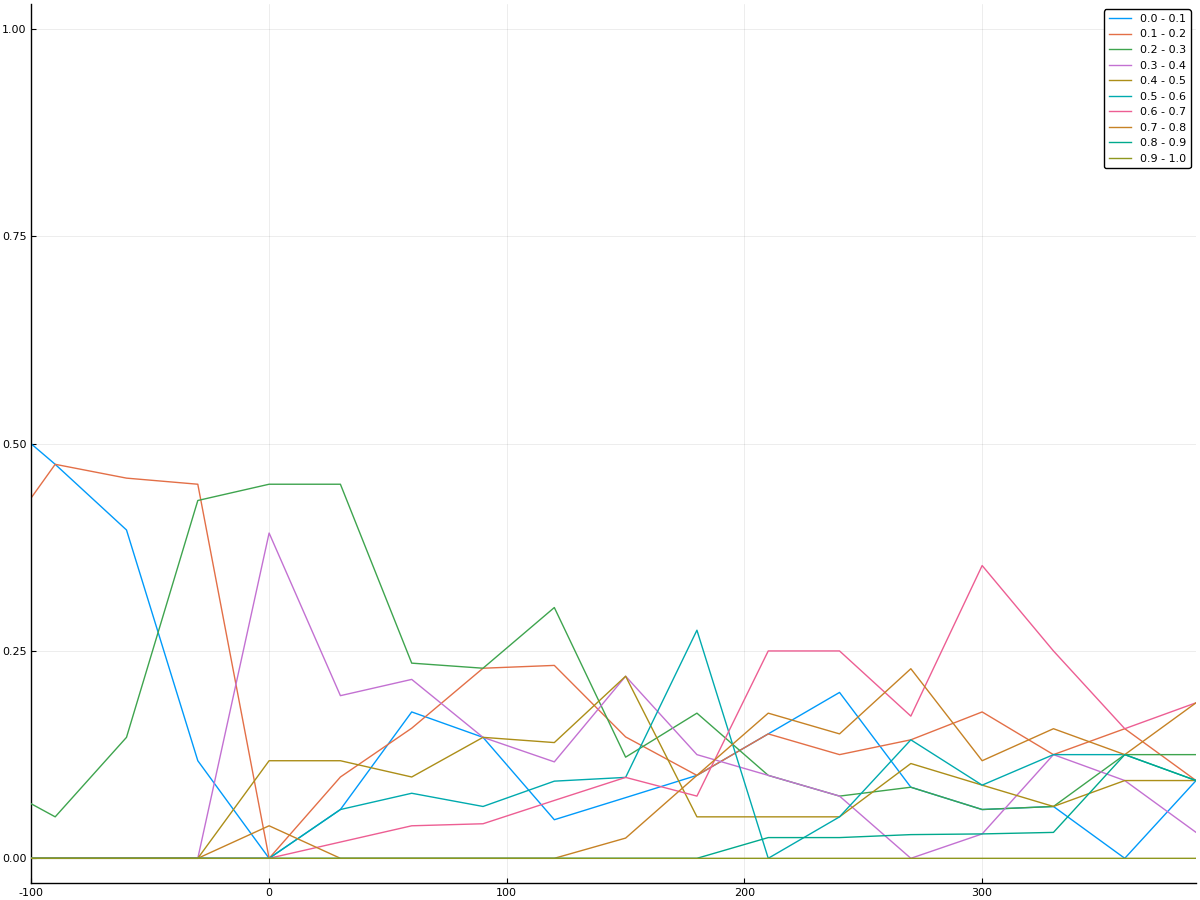

In [125]:
x = [x.value for x in collect(keys(dist_at_t))]
sp = sortperm(x); x = x[sp]
p = plot()
nbins = collect(bins)
for i in 1:10
    y = [x[i] for x in values(dist_at_t)][sp]
    plot!(p,x,y, label="$(nbins[i]) - $(nbins[i+1])")
end
plot!(p, xlim=(-100,390), size=(1200,900))
p

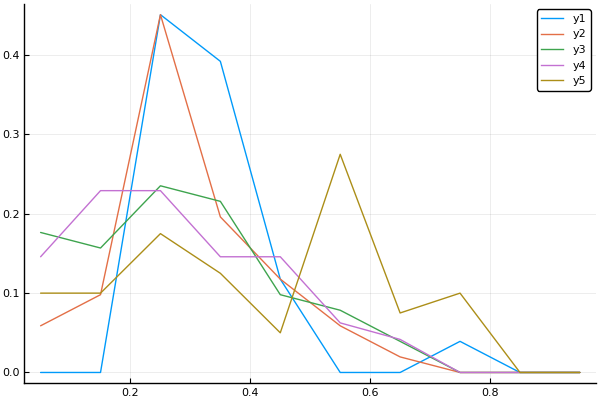

In [131]:
plot(0.05:0.1:1., dist_at_t[Day(0)])
plot!(0.05:0.1:1., dist_at_t[Day(30)])
plot!(0.05:0.1:1., dist_at_t[Day(60)])
plot!(0.05:0.1:1., dist_at_t[Day(90)])
plot!(0.05:0.1:1., dist_at_t[Day(180)])

In [127]:
log(2)

0.6931471805599453

In [128]:
log(10)

2.302585092994046

In [129]:
f = dist_at_t[Day(210)]

10-element Array{Float64,1}:
 0.15 
 0.15 
 0.1  
 0.1  
 0.05 
 0.0  
 0.25 
 0.175
 0.025
 0.0  

In [130]:
-sum((f .+ 1e-6).*log.(f .+ 1e-6))

1.9232926770154954

In [32]:
i = 19
traj = freqtraj_cf[0.5][i]
ac = FluTools.derivative_autocorrelation([traj],:active)

5-element Array{Pair{Any,Any},1}:
   0 days => [1.0, 1.0] 
  30 days => [-1.0, 1.0]
  60 days => [1.0, 1.0] 
  90 days => [-1.0, 1.0]
 120 days => [-1.0, 1.0]

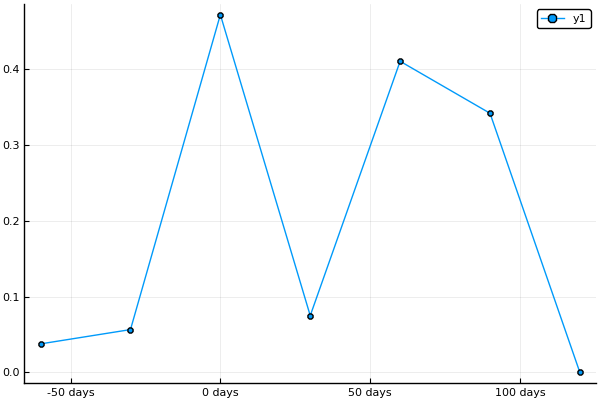

In [33]:
plot(traj.t, traj.freq, marker=:o)

In [34]:
i = 1:10
traj = freqtraj_cf[0.5][i]
ac = FluTools.derivative_autocorrelation(traj,:active)

33-element Array{Pair{Any,Any},1}:
   0 days => [10.0, 10.0]
  30 days => [-6.0, 10.0]
  60 days => [-5.0, 7.0] 
  90 days => [-7.0, 7.0] 
 120 days => [-1.0, 5.0] 
 150 days => [-1.0, 3.0] 
 180 days => [0.0, 2.0]  
 210 days => [2.0, 2.0]  
 240 days => [2.0, 2.0]  
 270 days => [0.0, 2.0]  
 300 days => [-1.0, 1.0] 
 330 days => [1.0, 1.0]  
 360 days => [1.0, 1.0]  
          ⋮              
 630 days => [1.0, 1.0]  
 660 days => [-1.0, 1.0] 
 690 days => [-1.0, 1.0] 
 720 days => [-1.0, 1.0] 
 750 days => [-1.0, 1.0] 
 780 days => [1.0, 1.0]  
 810 days => [1.0, 1.0]  
 840 days => [-1.0, 1.0] 
 870 days => [-1.0, 1.0] 
 900 days => [1.0, 1.0]  
 930 days => [1.0, 1.0]  
 960 days => [1.0, 1.0]  

In [35]:
traj.t

ErrorException: type Array has no field t

In [36]:
lost = freqtraj_cf[0.5][findall(x->x.fixation==:lost, freqtraj_cf[0.5])];
fixed = freqtraj_cf[0.5][findall(x->x.fixation==:fixed, freqtraj_cf[0.5])];

In [37]:
acl = FluTools.derivative_autocorrelation(lost, :active)
acf = FluTools.derivative_autocorrelation(fixed, :active)
acall = FluTools.derivative_autocorrelation(freqtraj_cf[0.5], :active);

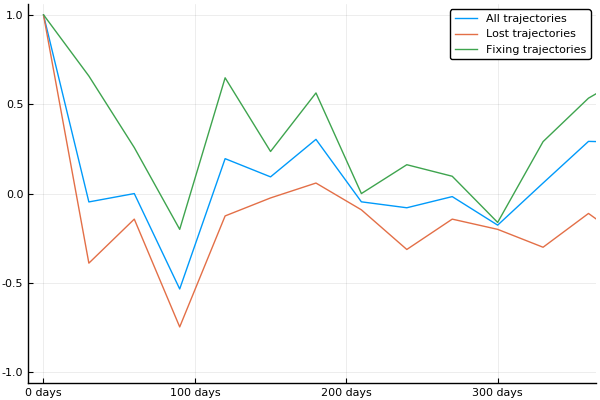

In [38]:
plot(xlim=(Dates.value(Day(-10)), Dates.value(Day(365)) ))
plot!([x[1] for x in acall], [x[2][1]/x[2][2] for x in acall], label="All trajectories")
plot!([x[1] for x in acl], [x[2][1]/x[2][2] for x in acl], label="Lost trajectories")
plot!([x[1] for x in acf], [x[2][1]/x[2][2] for x in acf], label="Fixing trajectories")

In [39]:
acf

55-element Array{Pair{Any,Any},1}:
    0 days => [35.0, 35.0]
   30 days => [23.0, 35.0]
   60 days => [9.0, 35.0] 
   90 days => [-7.0, 35.0]
  120 days => [22.0, 34.0]
  150 days => [8.0, 34.0] 
  180 days => [18.0, 32.0]
  210 days => [0.0, 32.0] 
  240 days => [5.0, 31.0] 
  270 days => [3.0, 31.0] 
  300 days => [-5.0, 31.0]
  330 days => [9.0, 31.0] 
  360 days => [16.0, 30.0]
           ⋮              
 1290 days => [0.0, 2.0]  
 1320 days => [0.0, 2.0]  
 1350 days => [2.0, 2.0]  
 1380 days => [0.0, 2.0]  
 1410 days => [0.0, 2.0]  
 1440 days => [-1.0, 1.0] 
 1470 days => [-1.0, 1.0] 
 1500 days => [1.0, 1.0]  
 1530 days => [-1.0, 1.0] 
 1560 days => [-1.0, 1.0] 
 1590 days => [1.0, 1.0]  
 1620 days => [1.0, 1.0]  

In [40]:
length(freqtraj_cf[0.5])

107